In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
file = open("temp_model.pickle",'rb')
df = pickle.load(file)
df.head()

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE


In [3]:
df.dtypes

DWG Number          object
RLocation           object
Tag                 object
Area               float64
Type                object
Loop Number        float64
Location           float64
Description         object
Manufacturer       float64
Model Number       float64
Comment            float64
Class Name          object
PnPID                int64
Area No            float64
Unit No            float64
Supplied By         object
Status              object
Sequence Number    float64
Suffix              object
Instrument Spec    float64
Spec Issued        float64
PO Issued          float64
Signal Type 1       object
Signal Type 2       object
Signal Type 3       object
dtype: object

In [34]:
lats = []
lons = []

for row in df['RLocation']:
    if type(row) != str:
        lat,lon = (None,None)
    else:
        lat,lon = tuple(str(row).split(','))
        lat = int(lat)
        lon = int(lon)
    lats.append(lat)
    lons.append(lon)
df["Lat"] = lats
df["Long"] = lons 

In [35]:
df['RLocation'].notna().head(20)

0      True
1      True
2     False
3      True
4     False
5      True
6      True
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17    False
18     True
19    False
Name: RLocation, dtype: bool

In [36]:
df_located = df[['RLocation','Lat','Long']][df['RLocation'].notna()]

In [37]:
df_located.describe()

,Lat,Long
count,97.000000,97.000000
mean,376.824742,292.587629
std,150.514673,190.005688
min,266.000000,83.000000
25%,294.000000,117.000000
50%,300.000000,158.000000
75%,535.000000,557.000000
max,774.000000,564.000000


In [38]:
X = np.array(df_located)
X = X[:,1:3]

In [39]:
X[:20]

array([[298.0, 561.0],
       [300.0, 561.0],
       [299.0, 562.0],
       [300.0, 561.0],
       [301.0, 562.0],
       [302.0, 563.0],
       [301.0, 564.0],
       [301.0, 564.0],
       [299.0, 563.0],
       [771.0, 289.0],
       [771.0, 291.0],
       [773.0, 292.0],
       [774.0, 293.0],
       [774.0, 292.0],
       [773.0, 292.0],
       [773.0, 292.0],
       [534.0, 315.0],
       [537.0, 318.0],
       [536.0, 316.0],
       [535.0, 318.0]], dtype=object)

In [40]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


Estimated number of clusters: 7
Estimated number of noise points: 0


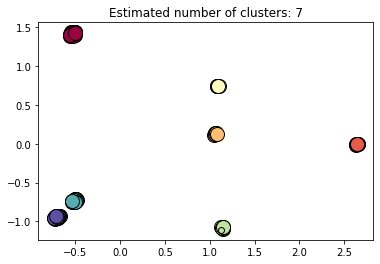

In [49]:
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
# Higher min_samples or lower eps indicate higher density necessary to form a cluster.
db = DBSCAN(eps=0.03, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [50]:
db.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### With the small adjust ment in eps(cluster radius) and min_sample(minimum cluster size) we were a ble to group locations into clusters that represent unit. This allow us to bin the locations into each unit.

In [51]:
df_located["unit_label"] = db.labels_

In [53]:
df_located.index

Int64Index([  0,   1,   3,   5,   6,   8,  16,  18,  21,  27,  28,  29,  31,
             32,  33,  38,  44,  45,  46,  47,  51,  54,  55,  61,  62,  63,
             64,  65,  66,  79,  81,  83,  84,  85,  92,  96, 100, 101, 102,
            103, 104, 105, 118, 122, 123, 124, 135, 136, 137, 141, 142, 155,
            173, 176, 177, 179, 189, 197, 198, 199, 200, 202, 203, 206, 208,
            209, 210, 236, 237, 240, 241, 242, 243, 266, 267, 268, 269, 271,
            279, 287, 291, 295, 297, 299, 300, 303, 304, 307, 308, 309, 322,
            324, 325, 326, 328, 332, 337],
           dtype='int64')

In [55]:
df["unit_label"] = None
df.iloc[df_located.index, -1] = db.labels_

In [66]:
pd.set_option('display.max_rows',100)
df.iloc[:,[0,1,-1]][df["RLocation"].notna()]

,DWG Number,RLocation,unit_label
0,PID-143,"298,561",0
1,PID-143,"300,561",0
3,PID-143,"299,562",0
5,PID-143,"300,561",0
6,PID-143,"301,562",0
8,PID-143,"302,563",0
16,PID-143,"301,564",0
18,PID-143,"301,564",0
21,PID-143,"299,563",0
27,PID-101,"771,289",1


#### We can now use unit_label enumeration as a target variable. This effectively bined the locations into categorical variables. We can use these labeled location now as training set for the machine learning algorithm to classify each intrument tags into the location. In this data set, this will be trivial since P&ID number is tied directly 1 to 1 with the location. None the less, we can mix other attributes in and provide a general framework for predicting the location of the instrument tag.